# Test Sentiment Analysis

In [1]:
#Résolution problème plotly
!pip install plotly
import plotly.io as pio
pio.renderers.default='iframe'

In [2]:
import datetime
import copy as c
import random
import collections
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px 
import re
!pip install afinn
from afinn import Afinn
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
!pip install textblob
from textblob import TextBlob

# pour importer:exporter des données vers MinIO (répertoire SSP Cloud)
!pip install s3fs
import s3fs
import os

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

### Import depuis une copie locale

In [4]:
#On récupère directement le dataset nettoyé
# url_local=r"C:\Users\Antoine\Downloads\clean_ecb_speeches_dataset.csv"
# df=pd.read_csv(url_local,sep = ",",encoding='utf-8')

## Import depuis MinIO

#### Méthode fonctionnant uniquement depuis SSP Cloud

In [5]:
# BUCKET = "aissac"
# FILE_KEY_S3 = "Projet_Python_2A/clean_ecb_speeches_dataset.csv"
# FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3

# #https://minio.lab.sspcloud.fr/aissac/Projet_Python_2A/clean_ecb_speeches_dataset.csv

# with fs.open(FILE_PATH_S3, mode="rb") as file_in:
#     df = pd.read_csv(file_in,sep = ",",encoding='utf-8')

#### Méthode générale

In [6]:

url="https://minio.lab.sspcloud.fr/aissac/Projet_Python_2A/clean_ecb_speeches_dataset.csv"

df=pd.read_csv(url,sep = ",",encoding='utf-8')

In [7]:
df

,date,speakers,title,subtitle,contents,Year,Month,Day,DayofWeek,DayofWeek_str,Month_str
0,2021-12-10,Fabio Panetta,The present and future of money in the digital...,"Lecture by Fabio Panetta, Member of the Execut...",SPEECH The present and future of money in ...,2021,12,10,5,Friday,December
1,2021-12-08,Isabel Schnabel,Monetary policy and financial stability,"Speech by Isabel Schnabel, Member of the Execu...",SPEECH Monetary policy and financial stabi...,2021,12,8,3,Wednesday,December
2,2021-12-08,Luis de Guindos,Macroprudential policy for non-bank financial ...,"Speech by Luis de Guindos, Vice-President of t...",SPEECH Macroprudential policy for non-bank...,2021,12,8,3,Wednesday,December
3,2021-12-08,Christine Lagarde,Macroprudential policy in Europe – the future ...,"Welcome remarks by Christine Lagarde, Presiden...",SPEECH Macroprudential policy in Europe – ...,2021,12,8,3,Wednesday,December
4,2021-11-29,Christine Lagarde,Dialogue in a changing world,"Lectio Magistralis by Christine Lagarde, Presi...",SPEECH Dialogue in a changing world Lect...,2021,11,29,1,Monday,November
...,...,...,...,...,...,...,...,...,...,...,...
2329,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...,1997,5,13,2,Tuesday,May
2330,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...,1997,4,30,3,Wednesday,April
2331,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...,1997,4,22,2,Tuesday,April
2332,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...,1997,3,10,1,Monday,March


# Librairies non spécialisées

In [8]:
# https://ednafernandes.medium.com/three-python-libraries-for-sentiment-analysis-c189655e0d9b
#Article intéressant pour 3 librairies classiques/basiques pour l'analyse de sentiments
# TextBlob
# AFINN
# Vader

## AFINN

In [9]:
afinn = Afinn()
#exemple :
afinn.score('This is utterly excellent!')

3.0

In [10]:
"""from afinn import Afinn
def afinn_polarity(text):
    return Afinn().score(text)
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
df['polarity'] = df[text].apply(afinn_polarity)
df['classification'] = df['polarity'].apply(getAnalysis)"""

"from afinn import Afinn\ndef afinn_polarity(text):\n    return Afinn().score(text)\ndef getAnalysis(score):\n    if score < 0:\n        return 'Negative'\n    elif score == 0:\n        return 'Neutral'\n    else:\n        return 'Positive'\ndf['polarity'] = df[text].apply(afinn_polarity)\ndf['classification'] = df['polarity'].apply(getAnalysis)"

In [11]:
#Premier test du score AFINN
start = time.time()
N=random.randrange(0, len(df))
print("Score :", afinn.score(df["contents"][N]))
end = time.time()
print("Temps pris :", end-start)
#Une première estimation donne une durée totale d'analyse d'un peu plus de 6 minutes pour tous les discours

Score : 88.0
Temps pris : 0.12486124038696289


In [12]:
start = time.time()

df["afinn-score"]=pd.Series(dtype=int)
def afinn_score(text):
    return afinn.score(text)

df["afinn-score"]=df["contents"].apply(afinn_score)

end = time.time()
print("Temps pris :", end-start) #~3 minutes

Temps pris : 230.49008059501648


Score moyen : 91.70522707797772
Score médian : 85.0


<AxesSubplot:>

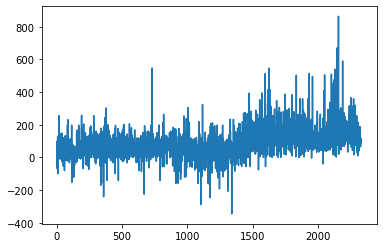

In [13]:
print("Score moyen :", df["afinn-score"].mean())
print("Score médian :",df["afinn-score"].median())

df["afinn-score"].plot()

In [14]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=90
fig=df.rolling(val, on="date").mean().plot(x="date",y="afinn-score",backend='plotly', title="Score AFINN")

fig.show()

## TextBlob

In [13]:
"""from textblob import TextBlob
def textblob_polarity(text):
 return TextBlob(text).sentiment.polarity
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
df['polarity'] = df[text].apply(textblob_polarity)
df['classification'] = df['polarity'].apply(getAnalysis)"""

"from textblob import TextBlob\ndef textblob_polarity(text):\n return TextBlob(text).sentiment.polarity\ndef getAnalysis(score):\n    if score < 0:\n        return 'Negative'\n    elif score == 0:\n        return 'Neutral'\n    else:\n        return 'Positive'\ndf['polarity'] = df[text].apply(textblob_polarity)\ndf['classification'] = df['polarity'].apply(getAnalysis)"

In [14]:
start = time.time()

df["textblob-score"]=pd.Series(dtype=int)
def textblob_score(text):
    return TextBlob(text).sentiment.polarity

df["textblob-score"]=df["contents"].apply(textblob_score)

end = time.time()
print("Temps pris :", end-start) #~40 secondes

Temps pris : 28.913647651672363


Score moyen : 0.1047167025466477
Score médian : 0.10119140438552868


<AxesSubplot:>

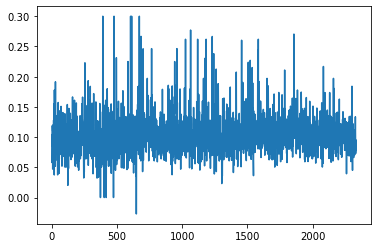

In [15]:
print("Score moyen :", df["textblob-score"].mean())
print("Score médian :",df["textblob-score"].median())

df["textblob-score"].plot()

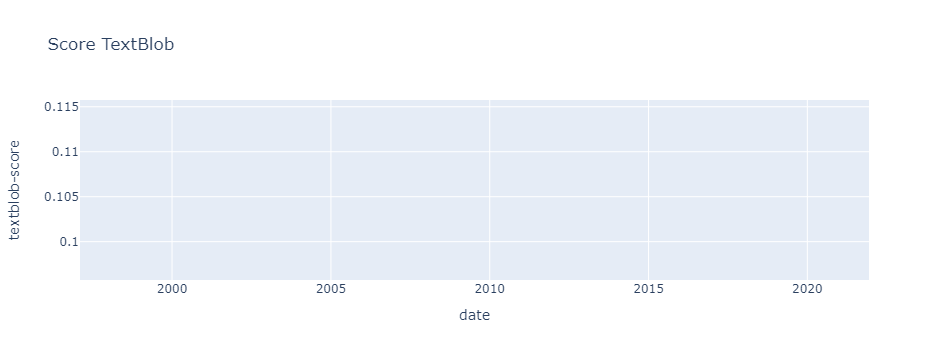

In [16]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=180
fig=df.rolling(val, on="date").mean().plot(x="date",y="textblob-score",backend='plotly', title="Score TextBlob")

fig.show()

## Vader Sentiment Lexicon

In [ ]:
"""from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def varder_polarity(text):
    return SentimentIntensityAnalyzer().polarity_scores(text)
def varder_analysis(score):
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.5:
        return 'Negative'
    else:
        return 'Neutral'
df['polarity'] = df[text].apply(varder_analysis)
df['classification'] = df['polarity'].apply(varder_analysis)"""

In [ ]:
##############################

# /!\ plus de 20 minutes /!\

##############################

start = time.time()

# Exemple de résultat de de modèle
# {'neg': 0.029, 'neu': 0.878, 'pos': 0.092, 'compound': 0.9999}
df["vader-score"]=pd.Series(dtype=int)

def vader_score(text):
    #retourne un dictionnaire
    return SentimentIntensityAnalyzer().polarity_scores(text)

def vader_score_compound(text):
    #retourne un float
    return SentimentIntensityAnalyzer().polarity_scores(text)['compound']

#df["vader-score"]=df["contents"].apply(vader_score_compound)

end = time.time()
print("Temps pris :", end-start) #23 minutes

In [ ]:
#print("Score moyen :", df["vader-score"].mean())
#print("Score médian :",df["vader-score"].median())

#df["vader-score"].plot()

## Corrélation entre les différents scores

In [ ]:
df['afinn-score'].corr(df['vader-score'])

In [17]:
df['afinn-score'].corr(df['textblob-score'])

0.13548532009111175

In [ ]:
df['vader-score'].corr(df['textblob-score'])

Les scores sont plus positifs que négatifs en général, mais il faudrait utiliser des librairies plus spécialisées (tournées vers l'économie et la finance).

# Librairies spécialisées

Au cours de nos recherches, plusieurs dictionnaires, listes ou bases de données sont apparus à plusieurs reprises comme des références dans l'analyse de sentiments de textes financiers comme :
- Loughran and McDonald
    - https://sraf.nd.edu/ et https://drive.google.com/file/d/1moS1tkh_AJafpcIFpktaSvZwrzv5d4ix/view
    - https://pypi.org/project/pysentiment2/#description 
- FED Financial Stability dictionary
    - https://www.federalreserve.gov/econres/notes/ifdp-notes/constructing-a-dictionary-for-financial-stability-20170623.htm
    - https://www.federalreserve.gov/econres/ifdp/files/ifdp1203.pdf [REPORT]
    - https://www.federalreserve.gov/econres/ifdp/files/ifdp1203-appendix.xlsx [DATA]
- 
- Dataset "financial_phrasebank" https://huggingface.co/datasets/financial_phrasebank

## Loughran and McDonald

In [15]:
!pip install pysentiment2
import pysentiment2 as ps
lm = ps.LM() #to use the Loughran and McDonald dictionary

     |████████████████████████████████| 1.9 MB 972 kB/s            


In [16]:
text=df["contents"][0]


tokens = lm.tokenize(text)
score = lm.get_score(tokens)

score

{'Positive': 125,
 'Negative': 165,
 'Polarity': -0.13793103400713436,
 'Subjectivity': 0.09244501112768728}

### Polarity

In [17]:
def LM_polarity(text):
    '''Pour obtenir la polarité d'un texte selon le dictionnaire Loughran and McDonald'''
    '''Polarity= (Pos-Neg)/(Pos+Neg)'''
    #lm = pysentiment2.LM() 
    #to use the Loughran and McDonald dictionary
    tokens = lm.tokenize(text)
    return round(lm.get_score(tokens)['Polarity'],4)

In [18]:
start = time.time()

df["LM-polarity"]=pd.Series(dtype=float)

df["LM-polarity"]=df["contents"].apply(LM_polarity)

end = time.time()
print("Temps pris :", end-start, "secondes")
#Temps pris : 110.3992772102356 secondes

Temps pris : 90.82716679573059 secondes


In [19]:
print("Polarité moyenne :", df["LM-polarity"].mean()) #Polarité moyenne : -0.04744399141630894

print("Polarité médiane :",df["LM-polarity"].median()) #Polarité médiane : -0.06055

Polarité moyenne : -0.04777600685518417
Polarité médiane : -0.06135


### Subjectivity

In [20]:
def LM_subjectivity(text):
    '''Pour obtenir la subjectivité d'un texte selon le dictionnaire Loughran and McDonald'''
    '''Subjectivity= (Pos+Neg)/count'''
    #lm = pysentiment2.LM() 
    #to use the Loughran and McDonald dictionary
    tokens = lm.tokenize(text)
    return round(lm.get_score(tokens)['Subjectivity'],4) #on arrondit le résultat

In [21]:
start = time.time()

df["LM-subjectivity"]=pd.Series(dtype=float)
df["LM-subjectivity"]=df["contents"].apply(LM_subjectivity)

end = time.time()
print("Temps pris :", end-start, "secondes")
#Temps pris : 114.29144740104675 secondes

In [22]:
print("Subjectivité moyenne :", df["LM-polarity"].mean()) #Subjectivité moyenne : -0.04744399141630894

print("Subjectivité médiane :",df["LM-polarity"].median()) #Subjectivité médiane : -0.06055

Subjectivité moyenne : -0.04777600685518417
Subjectivité médiane : -0.06135


### Graphiques Polarité et Subjectivité

In [23]:
fig = px.line(df, x="date",y=["LM-polarity","LM-subjectivity"])
fig.show()
#peu lisible

<AxesSubplot:xlabel='Year,Month'>

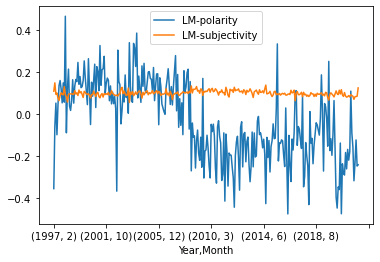

In [24]:
df1=df.groupby(["Year","Month"]).mean()
df1[["LM-polarity","LM-subjectivity"]].plot()
#une tendance se dégage pour la polarité

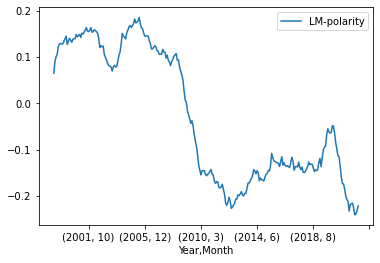

In [25]:
df2=df1.rolling(20).mean() #moyenne mobile sur 20 mois
fig=df2.plot(y="LM-polarity")

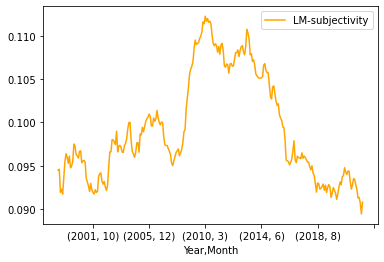

In [26]:
fig=df2.plot(y="LM-subjectivity", color='orange')

In [27]:
df.rolling(20, on="date").mean() #moyenne mobile sur 20 jours

,date,Day,DayofWeek,LM-polarity,LM-subjectivity,Month,Year,afinn-score
0,2021-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2329,1997-05-13,17.65,3.05,0.098085,0.087980,7.10,1997.25,117.85
2330,1997-04-30,18.90,3.00,0.092770,0.087755,7.20,1997.20,113.00
2331,1997-04-22,18.50,2.85,0.089275,0.089940,7.35,1997.15,109.60
2332,1997-03-10,17.90,2.70,0.076590,0.090130,7.45,1997.10,108.15


In [28]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=90
fig=df.rolling(val, on="date").mean().plot(x="date",y="LM-polarity",backend='plotly', title="Polarité")
fig.show()

In [29]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=200
fig=df.rolling(val, on="date").mean().plot(x="date",y="LM-subjectivity",backend='plotly', title="Subjectivité")

fig.show()

Les résultas obtenus semblent cohérents.

## FED Financial Stability dictionary

In [30]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 718 kB/s            


In [31]:
#FS Dictionary
fed1=pd.read_excel(r"https://www.federalreserve.gov/econres/ifdp/files/ifdp1203-appendix.xlsx", sheet_name=1)

In [32]:
fed1
#ce format de dataframe n'est pas facile à exploiter
#on va le transformer en deux listes

,Word,Positive,Negative
0,able,1.0,NaN
1,abnormally,NaN,1.0
2,abrupt,NaN,1.0
3,absorb,1.0,NaN
4,absorbed,1.0,NaN
...,...,...,...
386,worsen,NaN,1.0
387,worsened,NaN,1.0
388,worsening,NaN,1.0
389,worst,NaN,1.0


In [33]:
positive_words=fed1[fed1["Positive"].notna()]["Word"]
positive_list=positive_words.values.tolist()
#positive_list

In [34]:
negative_words=fed1[fed1["Negative"].notna()]["Word"]
negative_list=negative_words.values.tolist()
#negative_list

In [35]:
#FS Dictionary print
fed2=pd.read_excel(r"https://www.federalreserve.gov/econres/ifdp/files/ifdp1203-appendix.xlsx", sheet_name=2)
fed2
#on retrouve sous un autre format les mêmes informations que le premier dataframe

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Positive words,NaN,NaN,Negative words,NaN,NaN,NaN,NaN,NaN
1,able,mitigated,NaN,abnormally,destabilizing,exhausted,jeopardised,shortage,threats
2,absorb,mitigates,NaN,abrupt,deteriorate,expose,jeopardising,shortages,tough
3,absorbed,mitigating,NaN,abundant,deteriorated,exposed,jeopardize,shortfall,troubled
4,absorbing,mitigation,NaN,adverse,deteriorating,exposes,lackluster,shortfalls,tumbling
5,acceptable,opportunity,NaN,adversely,deterioration,exposing,lacklustre,shrank,turbulence
6,achievement,optimism,NaN,aggravate,deteriorations,fail,lagged,shrink,turbulences
7,adequately,outperformed,NaN,aggravated,detrimental,failed,lose,shrinking,turbulent
8,alleviated,positive,NaN,aggravating,difficult,failing,losing,shrunk,turmoil
9,alleviating,positively,NaN,aggravation,difficulties,fails,losses,slid,unable


In [36]:
#Non FS words
fed3=pd.read_excel(r"https://www.federalreserve.gov/econres/ifdp/files/ifdp1203-appendix.xlsx", sheet_name=3)
fed3

,Word,Non-FS (neutral),
0,abandoned,1,NaN
1,abate,1,NaN
2,abated,1,NaN
3,abnormal,1,NaN
4,abolition,1,NaN
...,...,...,...
1088,underpriced,1,NaN
1089,unfolded,1,NaN
1090,unnecessary,1,NaN
1091,uplift,1,NaN


In [37]:
neutral_list=fed3["Word"].values.tolist()
#neutral_list

### Calcul des deux grandeurs : FSS index et excitement index

Ces deux grandeurs sont celles mentionnées dans le rapport associé au dictionnaire de la FED. (federalreserve.gov/econres/ifdp/files/ifdp1203.pdf)

FSS index : $$   FSS=(Negativewords - Positivewords)/(Totalwords) $$

Excitement index : $$   FSS*=(Negativewords^2 + Positivewords^2)/(Totalwords) $$

In [41]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


def liste_mots(text,stopwords=stop_words):
    '''Fonction pour récupérer la liste des mots d'un texte brut'''
    text = re.sub(r'==.*?==+', ' ', text)
    text = text.replace('\n', ' ')
    text=text.replace('\'',' ')
    text=re.sub(r'[^\w\s]',' ',text) #retire la ponctuation
    text = re.sub(r'\d+',' ',text) #retire les nombres
    text=text.replace('%',' ')
    text=text.replace('+',' ')
    text=text.replace('=',' ')
    text=text.replace('*',' ')
    text=text.replace('_',' ')
    text=text.replace('-',' ')
    return [mot for mot in text.split() if mot.lower() not in list(stopwords)]

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
def FSS_index(text,positive_words=positive_list,negative_words=negative_list):
    '''Pour calculer le FSS index décrit dans le rapport de la FED'''
    '''FSS=(Negativewords - Positivewords)/(Totalwords)'''
    #positive_words et negative_words sont des listes
    negative_count=0
    positive_count=0
    L=liste_mots(text)
    for word in L:
        if (word in positive_words):
            positive_count+=1
        elif (word in negative_words):
            negative_count+=1
    return round((negative_count-positive_count)*100/len(L),3)

In [43]:
def excitement_index(text,positive_words=positive_list,negative_words=negative_list):
    '''Pour calculer l'excitement index décrit dans le rapport de la FED'''
    '''FSS*=(Negativewords^2 + Positivewords^2)/(Totalwords)'''
    #positive_words et negative_words sont des listes
    negative_count=0
    positive_count=0
    L=liste_mots(text)
    for word in L:
        if (word in positive_words):
            positive_count+=1
        elif (word in negative_words):
            negative_count+=1
    return round((negative_count**2+positive_count**2)/len(L),3)

In [44]:
start=time.time()

df["FSS-index"]=df["contents"].apply(FSS_index)

print("Temps pris :",time.time()-start) #41.49177670478821

Temps pris : 44.84216570854187


In [45]:
start=time.time()

df["excitement-index"]=df["contents"].apply(excitement_index)

print("Temps pris :",time.time()-start) #43.82283163070679

Temps pris : 35.41240930557251


In [46]:
fig = px.line(df, x="date",y=["FSS-index","excitement-index"])
fig.show()

In [47]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=300
fig=df.rolling(val, on="date").mean().plot(x="date",y="FSS-index",backend='plotly', title="FSS-index")

fig.show()

In [48]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=300
fig=df.rolling(val, on="date").mean().plot(x="date",y="excitement-index",backend='plotly', title="excitement-index")

fig.show()

In [49]:
df

,date,speakers,title,subtitle,contents,Year,Month,Day,DayofWeek,DayofWeek_str,Month_str,afinn-score,LM-polarity,LM-subjectivity,FSS-index,excitement-index
0,2021-12-10,Fabio Panetta,The present and future of money in the digital...,"Lecture by Fabio Panetta, Member of the Execut...",SPEECH The present and future of money in ...,2021,12,10,5,Friday,December,98.0,-0.1379,0.0924,0.450,0.725
1,2021-12-08,Isabel Schnabel,Monetary policy and financial stability,"Speech by Isabel Schnabel, Member of the Execu...",SPEECH Monetary policy and financial stabi...,2021,12,8,3,Wednesday,December,-67.0,-0.2604,0.1302,0.878,2.173
2,2021-12-08,Luis de Guindos,Macroprudential policy for non-bank financial ...,"Speech by Luis de Guindos, Vice-President of t...",SPEECH Macroprudential policy for non-bank...,2021,12,8,3,Wednesday,December,10.0,-0.2621,0.1287,0.731,1.084
3,2021-12-08,Christine Lagarde,Macroprudential policy in Europe – the future ...,"Welcome remarks by Christine Lagarde, Presiden...",SPEECH Macroprudential policy in Europe – ...,2021,12,8,3,Wednesday,December,-48.0,-0.3043,0.1443,2.308,1.012
4,2021-11-29,Christine Lagarde,Dialogue in a changing world,"Lectio Magistralis by Christine Lagarde, Presi...",SPEECH Dialogue in a changing world Lect...,2021,11,29,1,Monday,November,47.0,-0.1719,0.0831,0.979,0.941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2329,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...,1997,5,13,2,Tuesday,May,107.0,-0.0984,0.0993,0.327,0.283
2330,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...,1997,4,30,3,Wednesday,April,118.0,0.1111,0.0736,-0.292,0.149
2331,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...,1997,4,22,2,Tuesday,April,95.0,-0.0074,0.1133,0.477,0.589
2332,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...,1997,3,10,1,Monday,March,90.0,-0.0583,0.1481,1.150,1.538


## Copie locale des données

In [61]:
#pour obtenir une copie locale du dataset "nettoyé"
# path=r"C:\Users\Antoine\Downloads\sentiment_analysis_speeches_dataset.csv"
# df.to_csv(path_or_buf=path,
#           sep=',',
#           header=True,
#           index=False,
#           encoding='utf-8'
#          )

## Export des données vers MinIO

### /!\ Ne fonctionne que depuis SSP Cloud /!\

In [62]:
BUCKET_OUT = "aissac"
FILE_KEY_OUT_S3 = "Projet_Python_2A/sentiment_analysis_speeches_dataset.csv"
FILE_PATH_OUT_S3 = BUCKET_OUT + "/" + FILE_KEY_OUT_S3

with fs.open(FILE_PATH_OUT_S3, 'w') as file_out:
    df.to_csv(file_out)

## Dataset "financial_phrasebank"

In [ ]:
#!pip install datasets$
import datasets

In [ ]:
dataset = datasets.load_dataset("financial_phrasebank", 'sentences_allagree')

In [ ]:
pd.DataFrame.from_dict(dataset)